In [1]:
!pip install pytorch-tabnet
!pip install optuna

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import time
import importlib
import json

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

from sklearn import svm
from google.colab import output

from pytorch_tabnet.tab_model import  TabNetRegressor
np.random.seed(777)
#st0 = np.random.get_state()

output.clear()

In [72]:
if os.path.isdir('Stark_ML'):
    !rm -rf Stark_ML
    !git clone https://github.com/alezakuskin/Stark_ML
else:
    !git clone https://github.com/alezakuskin/Stark_ML

import Stark_ML.utils.optuning
import Stark_ML.models.base_models
import Stark_ML.utils.metrics
import Stark_ML.utils.terms
import Stark_ML.utils.testset
import Stark_ML.utils.plotting

importlib.reload(Stark_ML.models.base_models)
importlib.reload(Stark_ML.utils.optuning)
importlib.reload(Stark_ML.utils.metrics)
importlib.reload(Stark_ML.utils.plotting)

from Stark_ML.models.base_models import *
from Stark_ML.utils.optuning import *
from Stark_ML.utils.metrics import *
from Stark_ML.utils.terms import *
from Stark_ML.utils.testset import *
from  Stark_ML.utils.plotting import *

output.clear()

# Data preprocessing

In [3]:
data = pd.read_excel('/content/Stark_ML/Source_files/Stark_data.xlsx',
                     sheet_name='Experimental',
                     usecols='A:BC'
                   )
data['Term'] = term_to_number(data['Term'])
data['Term.1'] = term_to_number(data['Term.1'])

In [4]:
#Defining elements to exclude from training set
elements_to_exclude = ['S', 'Mg', 'Mn']

#Separating into data for width and shift prediction
data_width = data[np.isnan(data['w (A)']) == False]
data_width_elements = data_width.loc[data_width['Element'].isin(elements_to_exclude)]
data_width = data_width.drop(data_width_elements.index)
data_width = data_width.sort_values(by=['Z number'])

target_width = data_width['w (A)']
target_width_elements = data_width_elements['w (A)']

label_width = data_width.loc[:, ['Element', 'Wavelength']]
label_width_elements = data_width_elements.loc[:, ['Element', 'Wavelength']]
data_width = data_width.drop(columns = ['d (A)', 'w (A)'])
data_width_elements = data_width_elements.drop(columns = ['d (A)', 'w (A)'])


data_shift = data[np.isnan(data['d (A)']) == False]
data_shift = data_shift.sort_values(by=['Z number'])
target_shift = data_shift['d (A)']
label_shift = data_shift.loc[:, ['Element', 'Wavelength']]
data_shift = data_shift.drop(columns = ['w (A)', 'd (A)'])

#Selecting items for predicting both parameters simultaneously
data_both = data[(np.isnan(data['w (A)']) == False) & (np.isnan(data['d (A)']) == False)]
data_shift = data_shift.sort_values(by=['Z number'])
target_both = data_both.loc[:, ['w (A)', 'd (A)']]
label_both = data_both.loc[:, ['Element', 'Wavelength']]
data_both = data_both.drop(columns = ['w (A)', 'd (A)'])

print(f'Number of items with width: {data_width.shape[0]}')
print(f'Number of items with shift: {data_shift.shape[0]}')
print(f'Number of items with both parameters: {data_both.shape[0]}')
print()
print(f'Size of elements-exclusive test set: {data_width_elements.shape[0]}')

Number of items with width: 897
Number of items with shift: 351
Number of items with both parameters: 299

Size of elements-exclusive test set: 34


## Data visual description

In [5]:
data_width.describe()

,Wavelength,Z number,1s,2s,2p,3s,3p,3d,4s,4p,...,8p,8d,9s,10s,Multiplicity.1,Term.1,Parity.1,J.1,E upper,T
count,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,...,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,897.000000,8.970000e+02,897.000000
mean,437.237659,14.851728,1.769231,1.612040,3.460424,0.858417,1.943144,2.469342,0.332219,0.749164,...,0.001115,0.002230,0.001115,0.001115,2.899666,1.544036,0.603122,1.827202,2.113072e+05,16462.332219
std,216.218894,15.978406,0.421560,0.737235,2.179154,0.905723,2.720643,3.995171,0.687093,1.679233,...,0.033389,0.047193,0.033389,0.033389,1.247752,1.312079,0.489523,1.432334,3.325359e+06,9439.627870
min,113.416500,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.173231e+04,2950.000000
25%,283.999000,6.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,5.387426e+04,10970.000000
50%,471.315614,7.000000,2.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,1.500000,8.848342e+04,12500.000000
75%,541.520000,26.000000,2.000000,2.000000,6.000000,2.000000,6.000000,7.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,1.000000,2.000000,1.184278e+05,20800.000000
max,2058.130000,82.000000,2.000000,2.000000,6.000000,2.000000,6.000000,10.000000,2.000000,6.000000,...,1.000000,1.000000,1.000000,1.000000,7.000000,5.000000,1.000000,7.000000,9.968131e+07,50000.000000


In [6]:
data_width_stats = target_width.describe()
print(data_width_stats)

count    897.000000
mean       4.564198
std       12.780995
min        0.001500
25%        0.204444
50%        1.451247
75%        4.016393
max      180.500000
Name: w (A), dtype: float64


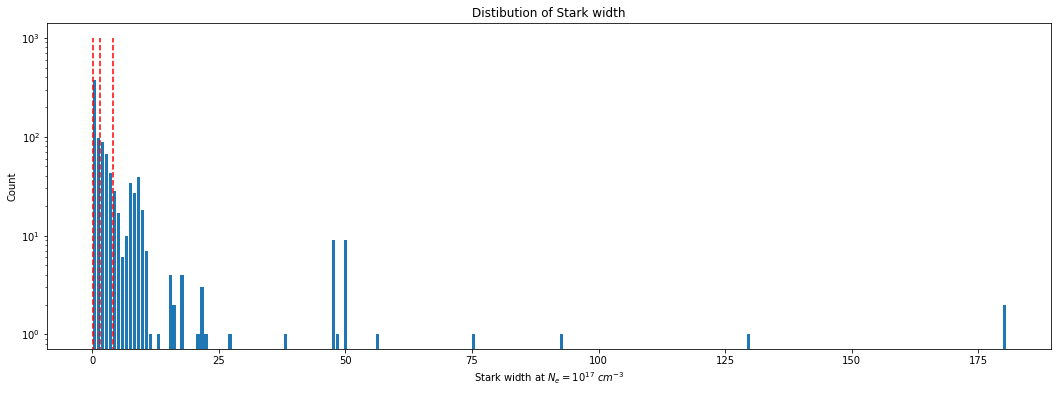

In [7]:
fig, ax = plt.subplots(figsize = (18, 6))
n, bins, patches = plt.hist(target_width, bins='auto', log=True, rwidth = 0.8)
ax.vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
ax.vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')

ax.set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
ax.set_ylabel('Count')
ax.set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

## Train - Test split

In [8]:
#Q1
data_test_q1, target_test_q1 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 'min',
                                              up_limit = 25,
                                              random_state = 7)

#Q2
data_test_q2, target_test_q2 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 25,
                                              up_limit = 50,
                                              random_state = 7)

#Q3
data_test_q3, target_test_q3 = test_selection(data_width,
                                              target_width,
                                              p = 0.17,
                                              low_limit = 50,
                                              up_limit = 75,
                                              random_state = 7)

#Q4
target_test_q4 = pd.Series()
while len(target_test_q4[target_test_q4 > 150]) < 1 or len(target_test_q4[(target_test_q4 > 70) & (target_test_q4 < 150)]) < 1:
  data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = None)
  
data_test_q4, target_test_q4 = test_selection(data_width,
                                                target_width,
                                                p = 0.17,
                                                low_limit = 75,
                                                random_state = 6)

print(target_test_q4[target_test_q4 > 70])

581    130.0
585    180.5
580     75.5
Name: w (A), dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


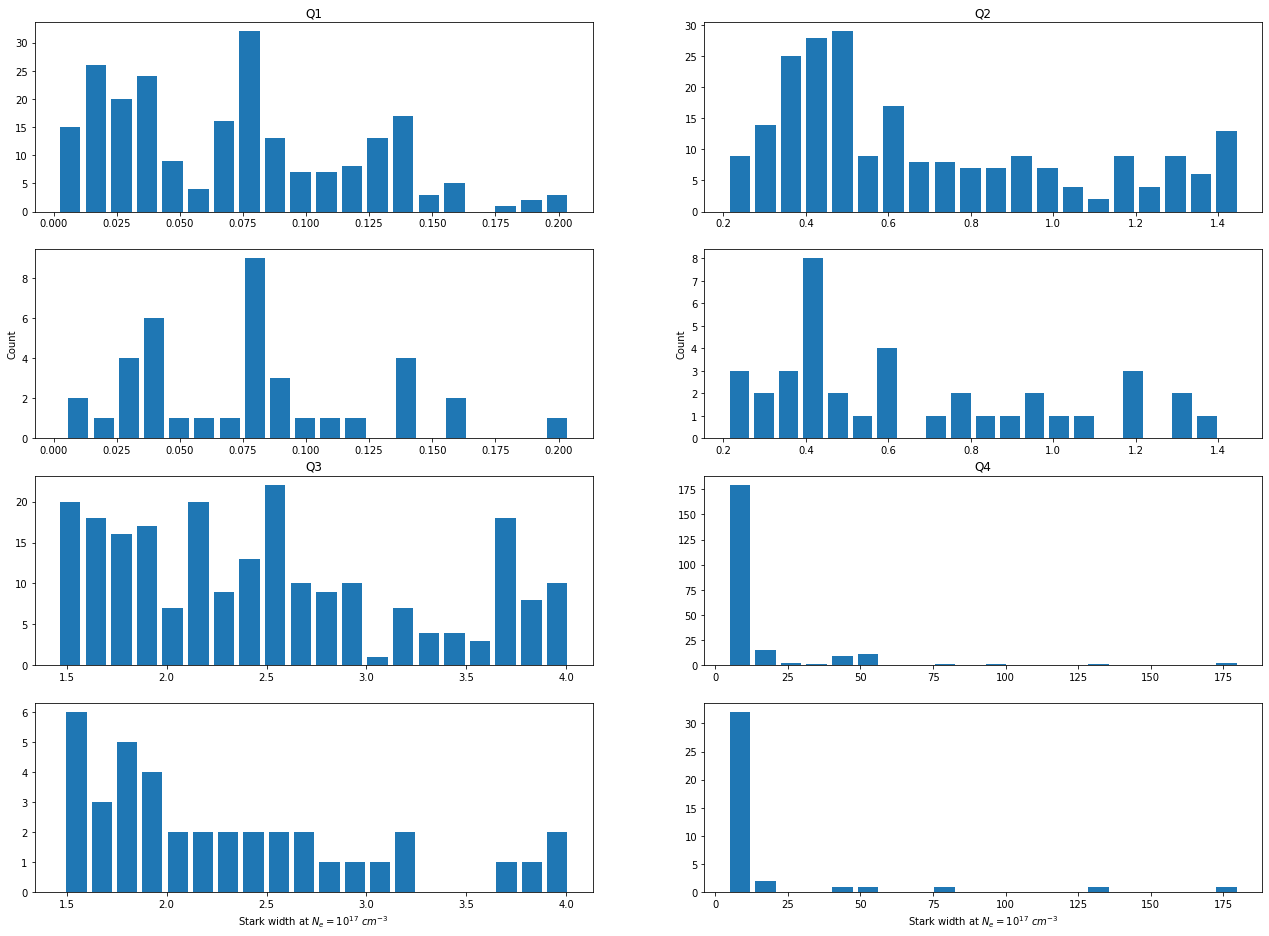

In [9]:
fig, axs = plt.subplots(4, 2, figsize = (22, 16), sharex = False)

axs[0, 0].hist(target_width[target_width <= data_width_stats['25%']], bins=20, log=False, rwidth = 0.8)
axs[1, 0].hist(target_test_q1, bins = 20, rwidth = 0.8)

axs[0, 1].hist(target_width[(target_width > data_width_stats['25%']) & (target_width <= data_width_stats['50%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[1, 1].hist(target_test_q2, bins = 20, rwidth = 0.8)

axs[2, 0].hist(target_width[(target_width > data_width_stats['50%']) & (target_width <= data_width_stats['75%'])],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 0].hist(target_test_q3, bins = 20, rwidth = 0.8)

axs[2, 1].hist(target_width[target_width > data_width_stats['75%']],
                            bins=20, log=False, rwidth = 0.8)
axs[3, 1].hist(target_test_q4, bins = 20, rwidth = 0.8)

axs[1, 0].get_shared_x_axes().join(axs[0, 0], axs[1, 0])
axs[1, 1].get_shared_x_axes().join(axs[0, 1], axs[1, 1])
axs[3, 0].get_shared_x_axes().join(axs[2, 0], axs[3, 0])
axs[3, 1].get_shared_x_axes().join(axs[2, 1], axs[3, 1])

axs[0, 0].set_title('Q1')
axs[2, 0].set_title('Q3')
axs[0, 1].set_title('Q2')
axs[2, 1].set_title('Q4')
axs[1, 0].set_ylabel('Count')
axs[1, 1].set_ylabel('Count')
axs[3, 0].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[3, 1].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
plt.show()

In [10]:
#Creating full train and test datasets
data_width_test, target_width_test = data_test_q1.append(data_test_q2), target_test_q1.append(target_test_q2)
data_width_test, target_width_test = data_width_test.append(data_test_q3), target_width_test.append(target_test_q3)
data_width_test, target_width_test = data_width_test.append(data_test_q4), target_width_test.append(target_test_q4)

data_width_train, target_width_train = data_width.drop(data_width_test.index), target_width.drop(target_width_test.index)

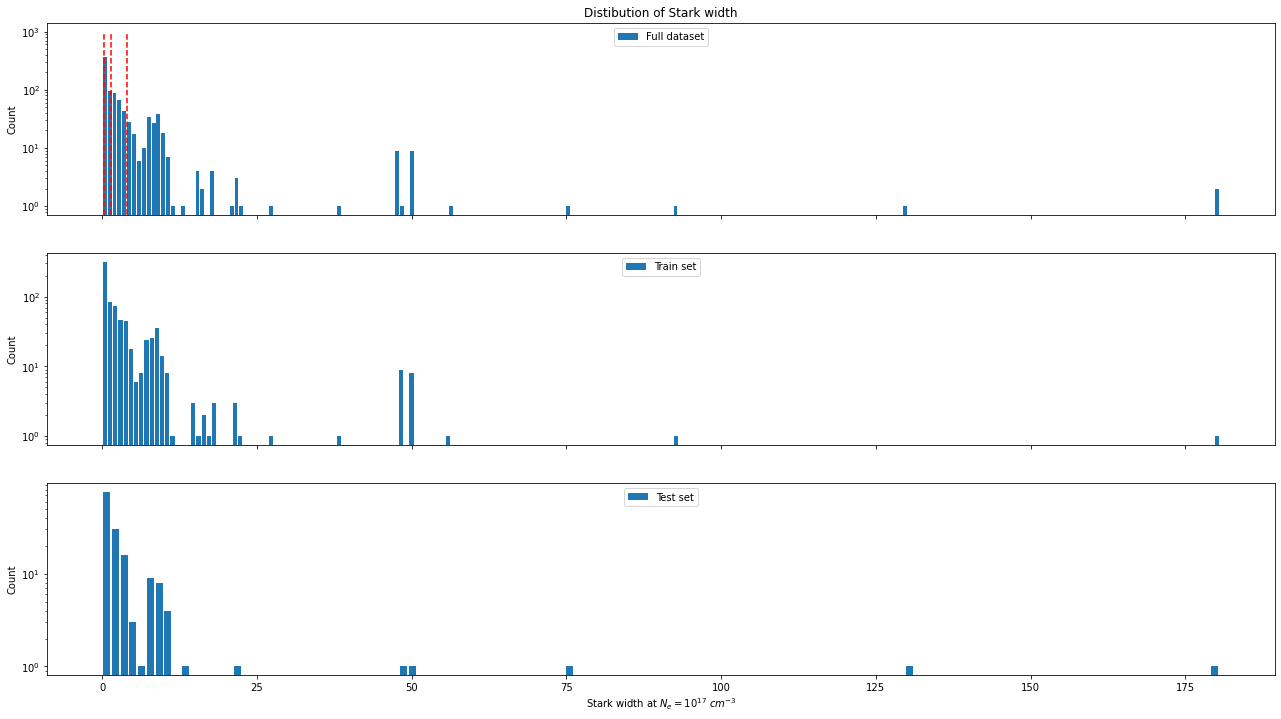

In [11]:
test_width_stats = target_width_test.describe()

fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = True)
axs[0].hist(target_width, bins='auto', log=True, rwidth = 0.8, label = 'Full dataset')
axs[1].hist(target_width_train, bins = 'auto', log = True, rwidth = 0.8, label = 'Train set')
axs[2].hist(target_width_test, bins = 'auto', log = True, rwidth = 0.8, label = 'Test set')


axs[0].vlines(x = data_width_stats['25%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['50%'], ymin = 0, ymax = 1000, ls='--', colors='r')
axs[0].vlines(x = data_width_stats['75%'], ymin = 0, ymax = 1000, ls='--', colors='r')
'''axs[1].vlines(x = test_width_stats['25%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['50%'], ymin = 0, ymax = 100, ls='--', colors='r')
axs[1].vlines(x = test_width_stats['75%'], ymin = 0, ymax = 100, ls='--', colors='r')
'''
axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')
axs[2].set_xlabel('Stark width at $N_e = 10^{17}$ $cm^{-3}$')
axs[0].set_ylabel('Count')
axs[1].set_ylabel('Count')
axs[2].set_ylabel('Count')
axs[0].set_title('Distibution of Stark width')

plt.show()

#plt.savefig('Width distribution.png', dpi = 300)

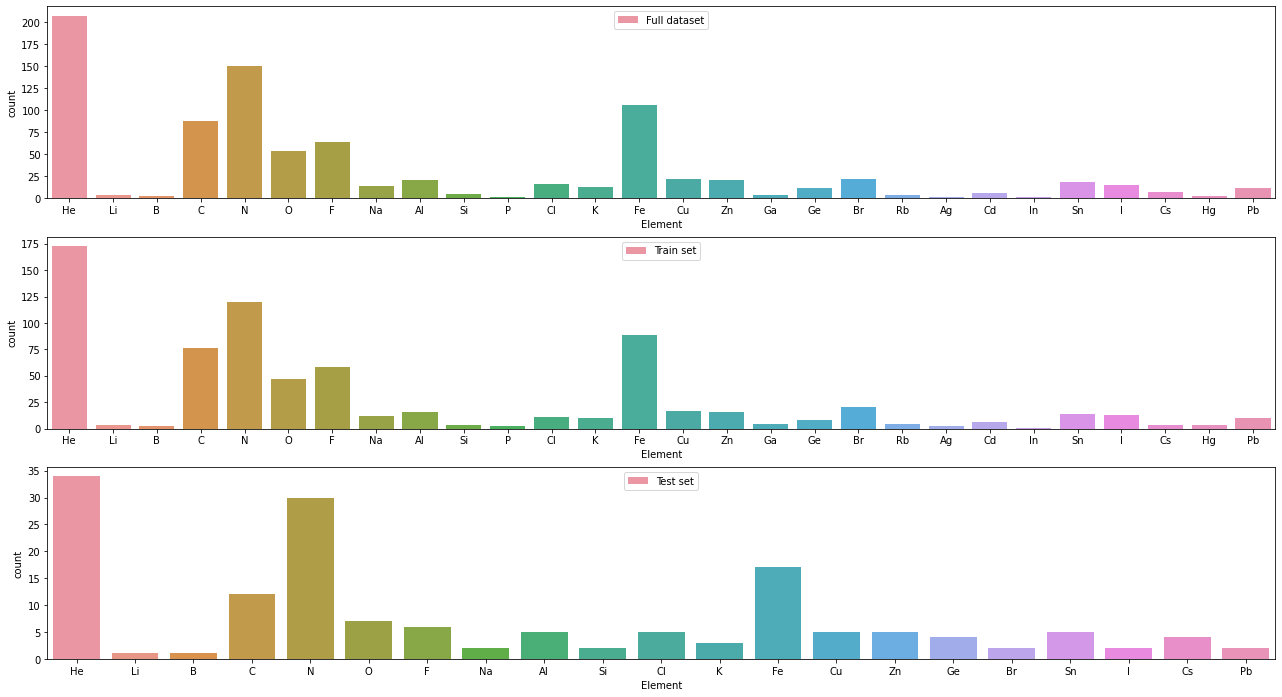

In [12]:
fig, axs = plt.subplots(3, 1, figsize = (22, 12), sharex = False)
sns.countplot(data = data_width, x = 'Element',  ax = axs[0], label = 'Full dataset')
sns.countplot(data = data_width_train.sort_values(by = ['Z number']), x = 'Element',  ax = axs[1], label = 'Train set')
sns.countplot(data = data_width_test.sort_values(by = ['Z number']), x = 'Element', ax = axs[2], label = 'Test set')

axs[0].legend(loc = 'upper center')
axs[1].legend(loc = 'upper center')
axs[2].legend(loc = 'upper center')

plt.show()

In [14]:
#Assigning proper variables
XW_train, YW_train = data_width_train.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_train
XW_test, YW_test = data_width_test.drop(columns=['Element', 'Wavelength', 'Z number']), target_width_test

print(XW_train.shape, YW_train.shape)
print(XW_test.shape, YW_test.shape)

XW_train = XW_train.sample(frac = 1, random_state = 777)
YW_train = YW_train.sample(frac = 1, random_state = 777)

print('\n', XW_train.shape, YW_train.shape)
print(XW_test.shape, YW_test.shape)
#XS_train, XS_test, YS_train, YS_test = train_test_split(data_shift, target_shift, test_size = 0.2, random_state = 7)
#XB_train, XB_test, YB_train, YB_test = train_test_split(data_both, target_both, test_size = 0.2, random_state = 7)

(743, 50) (743,)
(154, 50) (154,)

 (743, 50) (743,)
(154, 50) (154,)


#Models optimization

## KNN

In [37]:
KNN_params = {
    'n_neighbors' : [1, 150],
    'weights' : ['distance', 'uniform'],
    'leaf_size' : [1, 100],
    'p' : [1., 2.],
    'nfold' : 5,
    'squared_metrics' : False
    }

model_name = KNN

KNN_res = main(X = XW_train, y = YW_train, model_name = model_name, params = KNN_params, n_trials = 1000)

with open('KNN_optimal_parameters', 'w') as fp:
    json.dump(KNN_res.best_params, fp)

[I 2022-04-12 13:47:40,093] A new study created in memory with name: no-name-aada8abd-9d29-450d-96c7-04d61b987b62


Start hyperparameter optimization


/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning: `n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning: Progress bar only supports serial execution (`n_jobs=1`).
  warnings.warn("Progress bar only supports serial execution (`n_jobs=1`).")
[I 2022-04-12 13:47:41,768] Trial 1 finished with value: 5.096432971508369 and parameters: {'n_neighbors': 112, 'weights': 'distance', 'leaf_size': 58, 'p': 1.8510463365977305}. Best is trial 1 with value: 5.096432971508369.
[I 2022-04-12 13:47:41,837] Trial 0 finished with value: 10.013989279467872 and parameters: {'n_neighbors': 75, 'weights': 'uniform', 'leaf_size': 14, 'p': 1.7055113843566374}. Best is trial 1 with value: 5.096432971508369.
[I 2022-04-12 13:47:43,358] Trial 2 finished with value: 8.205093042778978 and parameters

Best parameters: {'n_neighbors': 3, 'weights': 'distance', 'leaf_size': 65, 'p': 1.9319232842057978}


Fitting old
Fitting new
Fitting default
Calculating bootstrap score for old
Calculating bootstrap score for new
Calculating bootstrap score for default


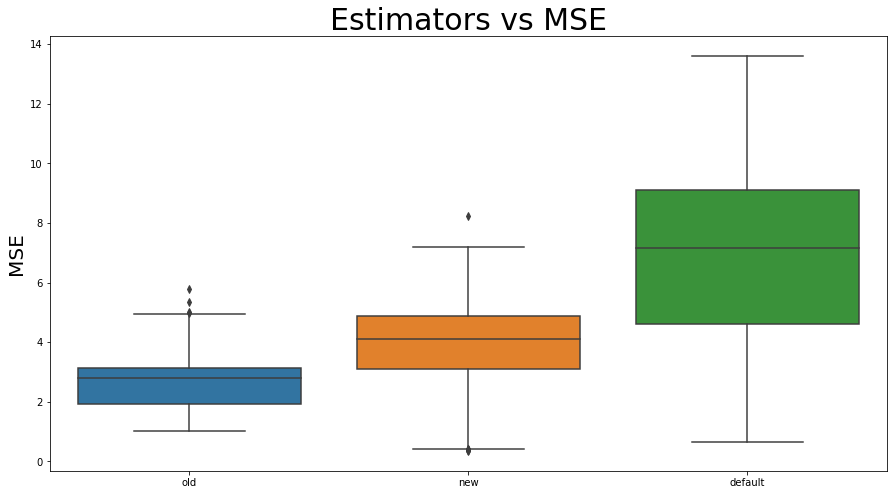

In [46]:
KNN_params = KNN_res.best_params

models = {}
models['old'] = KNeighborsRegressor(weights='distance',
                                          n_neighbors = 70,
                                          n_jobs = -1)
models['new'] = KNeighborsRegressor(**KNN_params)

models['default'] = KNeighborsRegressor(weights = 'uniform', n_neighbors = 3)

results = train_and_test_regressor(models, XW_train, YW_train, XW_test, YW_test)

plot_model_comparison(results)

In [47]:
KNN_df = KNN_res.trials_dataframe()
KNN_df

,number,value,datetime_start,datetime_complete,duration,params_leaf_size,params_n_neighbors,params_p,params_weights,state
0,0,10.013989,2022-04-12 13:47:40.106768,2022-04-12 13:47:41.837393,0 days 00:00:01.730625,14,75,1.705511,uniform,COMPLETE
1,1,5.096433,2022-04-12 13:47:40.113631,2022-04-12 13:47:41.767569,0 days 00:00:01.653938,58,112,1.851046,distance,COMPLETE
2,2,8.205093,2022-04-12 13:47:41.772185,2022-04-12 13:47:43.357943,0 days 00:00:01.585758,71,32,1.666567,uniform,COMPLETE
3,3,4.784772,2022-04-12 13:47:41.847137,2022-04-12 13:47:43.569646,0 days 00:00:01.722509,80,36,1.290381,distance,COMPLETE
4,4,10.033234,2022-04-12 13:47:43.370258,2022-04-12 13:47:45.012130,0 days 00:00:01.641872,85,87,1.931431,uniform,COMPLETE
...,...,...,...,...,...,...,...,...,...,...
995,995,5.021652,2022-04-12 13:57:46.637345,2022-04-12 13:57:47.845011,0 days 00:00:01.207666,67,1,1.961200,distance,COMPLETE
996,996,4.021390,2022-04-12 13:57:47.492627,2022-04-12 13:57:48.700113,0 days 00:00:01.207486,75,4,1.959803,distance,COMPLETE
997,997,5.084960,2022-04-12 13:57:47.850455,2022-04-12 13:57:49.112991,0 days 00:00:01.262536,75,96,1.903025,distance,COMPLETE
998,998,4.865306,2022-04-12 13:57:48.706061,2022-04-12 13:57:49.927569,0 days 00:00:01.221508,64,8,1.923475,distance,COMPLETE


In [52]:
optuna.visualization.plot_param_importances(KNN_res)

In [54]:
optuna.visualization.plot_slice(KNN_res, params = ['weights', 'n_neighbors'])

## Random Forest

In [74]:
RF_params = {
    'n_estimators' : 100,
    'max_depth' : [1, 50],
    'min_samples_split' : [2, 10],
    'min_samples_leaf' : [1, 10],
    'criterion' : ['squared_error', 'absolute_error', 'poisson'],
    'nfold' : 5,
    'squared_metrics' : False
    }

model_name = RandomForest

RF_res = main(X = XW_train, y = YW_train, model_name = model_name, params = RF_params, n_trials = 50)

with open('RF_optimal_parameters', 'w') as fp:
    json.dump(RF_res.best_params, fp)

[I 2022-04-12 15:46:28,985] A new study created in memory with name: no-name-61fa4491-119b-4cb5-8a63-fa5beb036313


Start hyperparameter optimization


/usr/local/lib/python3.7/dist-packages/optuna/study/study.py:397: FutureWarning:

`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.

/usr/local/lib/python3.7/dist-packages/optuna/study/_optimize.py:80: UserWarning:

Progress bar only supports serial execution (`n_jobs=1`).

[I 2022-04-12 15:46:38,725] Trial 0 finished with value: 4.8511160270819484 and parameters: {'max_depth': 27, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 0 with value: 4.8511160270819484.
[I 2022-04-12 15:46:42,622] Trial 2 finished with value: 9.711722105795207 and parameters: {'max_depth': 2, 'min_samples_split': 8, 'min_samples_leaf': 1, 'criterion': 'poisson'}. Best is trial 0 with value: 4.8511160270819484.
[I 2022-04-12 15:46:46,443] Trial 3 finished with value: 5.953852471592626 and parameters: {'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 6, 'criterion': '

Best parameters: {'max_depth': 29, 'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}


Fitting old
Fitting new
Fitting default
Calculating bootstrap score for old
Calculating bootstrap score for new
Calculating bootstrap score for default


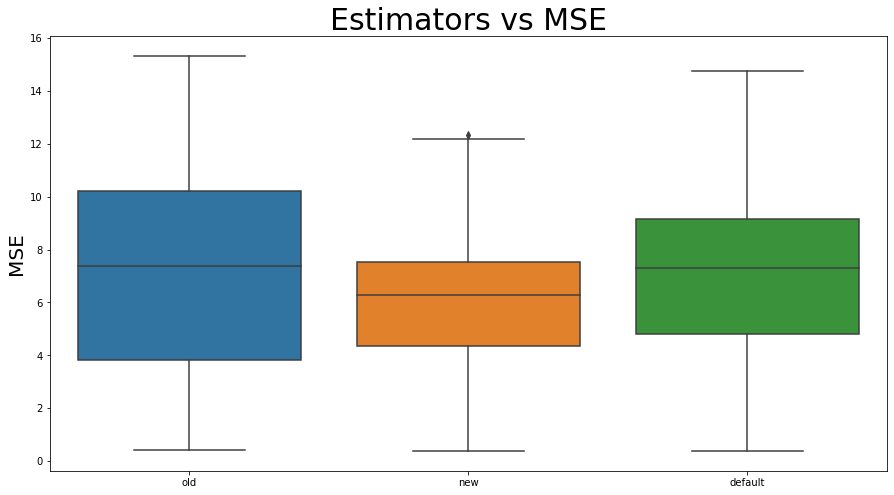

In [77]:
RF_params = RF_res.best_params

models_RF = {}
models_RF['old'] = RandomForestRegressor(n_estimators = 500,
                                      max_depth = 25,
                                      min_samples_leaf = 2,
                                      min_samples_split = 2,
                                      n_jobs = -1)
models_RF['new'] = RandomForestRegressor(**RF_params, n_estimators = 100)

models_RF['default'] = RandomForestRegressor()

results_RF = train_and_test_regressor(models_RF, XW_train, YW_train, XW_test, YW_test)
plot_model_comparison(results_RF)

Fitting 10
Fitting 11
Fitting 12
Fitting 13
Fitting 14
Fitting 15
Fitting 16
Fitting 17
Fitting 18
Fitting 19
Fitting 20
Fitting 21
Fitting 22
Fitting 23
Fitting 24
Fitting 25
Fitting 26
Fitting 27
Fitting 28
Fitting 29
Fitting 30
Fitting 31
Fitting 32
Fitting 33
Fitting 34
Fitting 35
Fitting 36
Fitting 37
Fitting 38
Fitting 39
Fitting 40
Fitting 41
Fitting 42
Fitting 43
Fitting 44
Fitting 45
Fitting 46
Fitting 47
Fitting 48
Fitting 49
Fitting 50
Fitting 51
Fitting 52
Fitting 53
Fitting 54
Fitting 55
Fitting 56
Fitting 57
Fitting 58
Fitting 59
Fitting 60
Fitting 61
Fitting 62
Fitting 63
Fitting 64
Fitting 65
Fitting 66
Fitting 67
Fitting 68
Fitting 69
Fitting 70
Fitting 71
Fitting 72
Fitting 73
Fitting 74
Fitting 75
Fitting 76
Fitting 77
Fitting 78
Fitting 79
Fitting 80
Fitting 81
Fitting 82
Fitting 83
Fitting 84
Fitting 85
Fitting 86
Fitting 87
Fitting 88
Fitting 89
Fitting 90
Fitting 91
Fitting 92
Fitting 93
Fitting 94
Fitting 95
Fitting 96
Fitting 97
Fitting 98
Fitting 99
Fitting 10

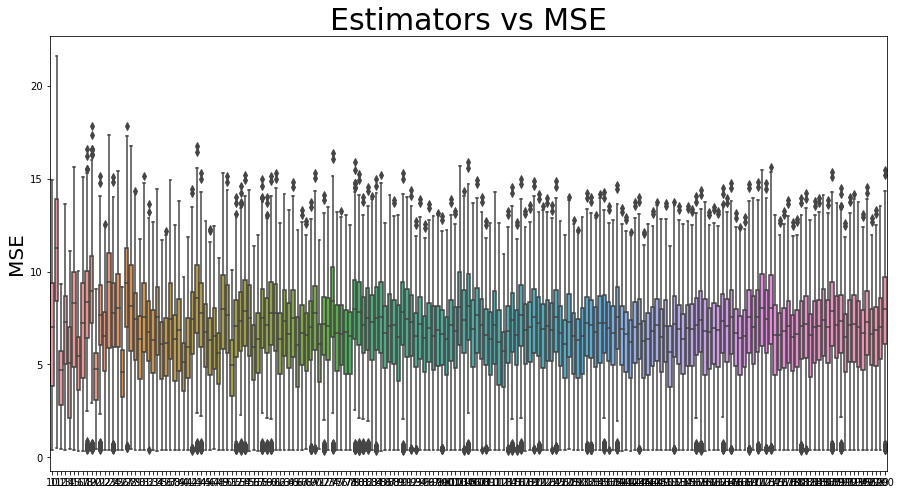

In [79]:
model = {}
for i in range(10, 201):
    model[f'{i}'] = RandomForestRegressor(**RF_params, n_estimators = i)

path = train_and_test_regressor(model, XW_train, YW_train, XW_test, YW_test)
plot_model_comparison(path)

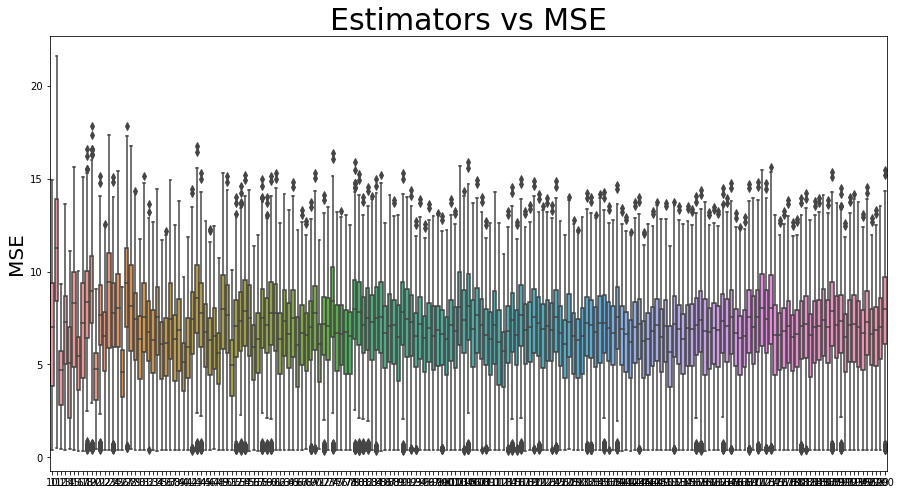

In [82]:
%matplotlib inline
plot_model_comparison(path)

In [76]:
optuna.visualization.plot_param_importances(RF_res)

10.896320547034469
1.7544492044331288
245.0102358038138
309.0224285862797
28.65465796897463
{'algorithm': 'kd_tree', 'leaf_size': 88, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 98, 'p': 1.00112252380585, 'weights': 'distance'}

 119.06761842210715
Fitting old
Fitting new
Fitting default
Calculating bootstrap score for old
Calculating bootstrap score for new
Calculating bootstrap score for default


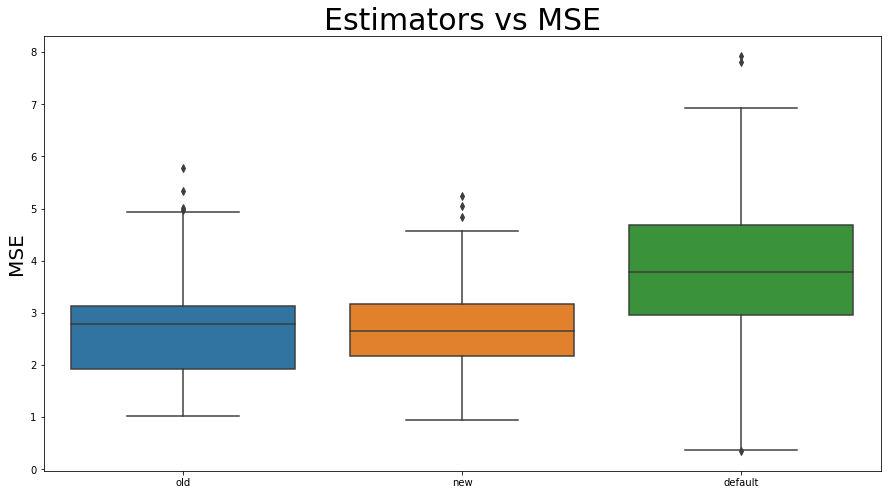

In [ ]:
score = 0
kf = KFold(5, shuffle = False)
for train, test in kf.split(XW_train):
    model = KNeighborsRegressor(**KNN_params, weights = 'distance')
    model.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    score += mean_squared_error(YW_train.iloc[test], model.predict(XW_train.iloc[test, :]),
                                squared = True)
    print(mean_squared_error(YW_train.iloc[test], model.predict(XW_train.iloc[test, :]),
                                squared = True))

print(model.get_params())
score /= 5

print(f"\n {score}")

results = train_and_test_regressor(models, XW_train, YW_train, XW_test, YW_test)

plot_model_comparison(results)


 New model: 1.3103127648347888
Old model 6.093652316330482

 New model: 94.13279799414171
Old model 180.50309037579498

 New model: 1.9385207526390318
Old model 17.627751401000655

 New model: 1.5507287691702138
Old model 4.404680224374737

 New model: 32.33420231762895
Old model 9.96914734680852

 New score 26.253312519682943
Old score 43.71966433286188
Fitting Old
Fitting New
Calculating bootstrap score for Old
Calculating bootstrap score for New


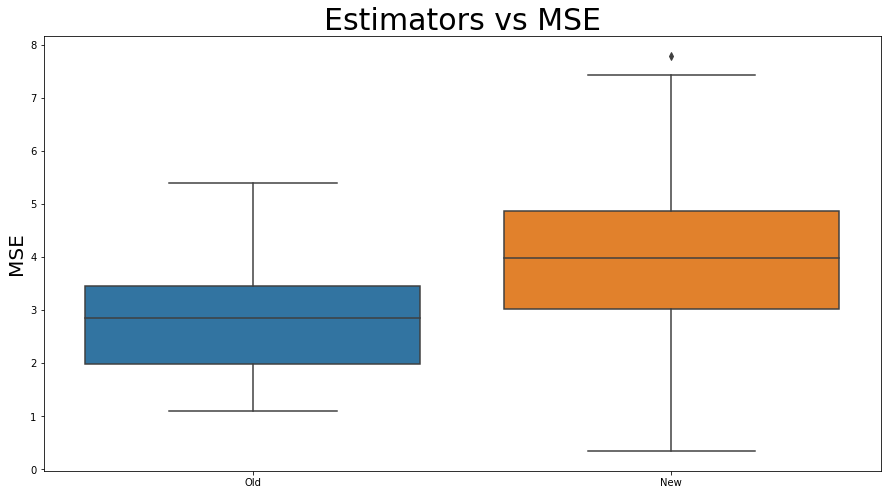

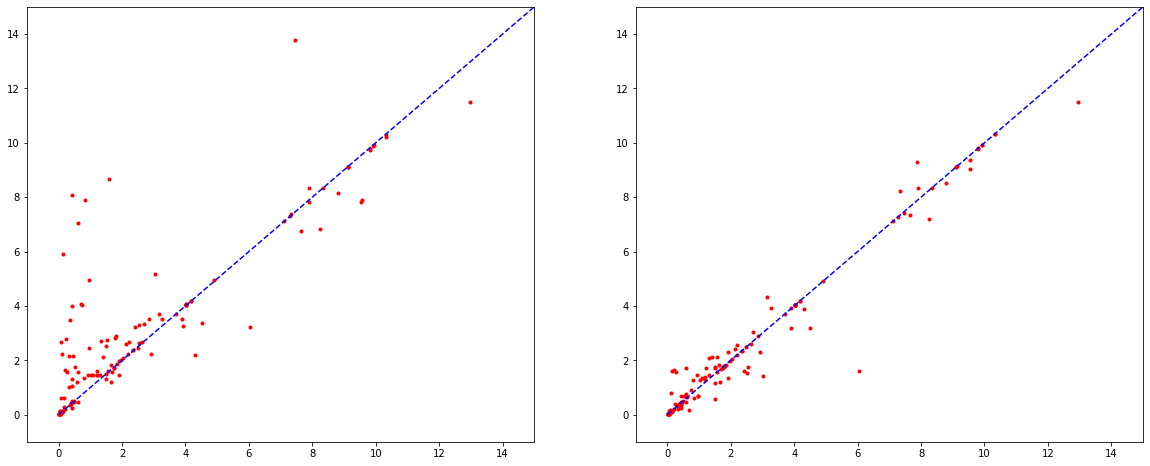

In [31]:
nfolds = 5
#kf = KFold(nfolds, shuffle = True, random_state=7)
kf = KFold(nfolds, shuffle = False)
score = 0
score_old = 0

for train, test in kf.split(XW_train):
    #print(XW_train.iloc[test, :])
    #print(YW_train.iloc[test])
    #break

    model = KNeighborsRegressor(**KNN_params, weights = 'distance')
    model_old = KNeighborsRegressor(n_neighbors = 70, weights = 'distance')
    
    model.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    model_old.fit(XW_train.iloc[train, :], YW_train.iloc[train])
    
    score += mean_squared_error(YW_train.iloc[test], model.predict(XW_train.iloc[test, :]),
                                squared = True)
    score_old += mean_squared_error(YW_train.iloc[test], model_old.predict(XW_train.iloc[test, :]),
                                squared = True)
    print('\n', 'New model:', mean_squared_error(YW_train.iloc[test], model.predict(XW_train.iloc[test, :]),
                                squared = True))
    print('Old model', mean_squared_error(YW_train.iloc[test], model_old.predict(XW_train.iloc[test, :]),
                                squared = True))
score /= nfolds
score_old /= nfolds

print(f"\n New score {score}")
print(f"Old score {score_old}")

models = {
    'Old' : model_old,
    'New' : model
}

rrr = train_and_test_regressor(models, XW_train, YW_train, XW_test.sample(frac = 1, random_state = 777), YW_test.sample(frac = 1, random_state = 777))
plot_model_comparison(rrr)

fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(YW_test, model_old.predict(XW_test), 'r.')
ax[1].plot(YW_test, model.predict(XW_test), 'r.')
for i in ax:
    i.plot([0, 170], [0, 170], color = 'b', ls = '--')
    i.set_xlim(-1, 15)
    i.set_ylim(-1, 15)
plt.show()